**DeepCGH: 3D computer generated holography using deep learning**

This notebook shows a simple implementation, training and testing of DeepCGH in a simple setting. First, we will generate a training dataset that consists of randomly distributed Disks. Then we will use this dataset to train a DeepCGH model. This trained model is then used to generate holograms of disks at desired locations. This tutorial is on 3D holograms with size 512x512*3. We provide extensively trained model for 512x512x3 and 1024x1024x3.

First, we import the necessary modules and we clone the DeepCGH Github repository into the working directory of this google colab session. Then we change the session's working directory to the folder that contains the repository.

In [ ]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from time import time
!git clone https://github.com/UNC-optics/DeepCGH.git
os.chdir('DeepCGH')

Now we can use `deepcgh.DeepCGH_Datasets` and `deepcgh.DeepCGH` to generate a dataset and train a DeepCGH model with it. Specifically:

`DeepCGH_Datasets`: is a module that synthesizes training data set.

`DeepCGH`: is the main module that contains the DeepCGH model and performs the training.

In [ ]:
from deepcgh import DeepCGH_Datasets, DeepCGH
from utils import GS3D, display_results, get_propagate

The next step specfies the characteristics of the training dataset that will be used to train the DeepCGH model:

In [ ]:
retrain = True
coordinates = False

data = {'path' : 'DeepCGH_Datasets/Disks',# path to store the data
        'shape' : (512, 512, 3),# shape of the holograms. The last dimension determines the number of depth planes
        'object_type' : 'Disk',# shape of the object in simulated images, can be disk, square, or line
        'object_size' : 10,# has no effect if object type is 'Line'
        'object_count' : [27, 48],# number of random objects to be created
        'intensity' : [0.2, 1],# the (range of) intensity of each object. If a range is specified, for each object the intensity is randomly determined
        'normalize' : True,# if the data is 3D, it'll normalize the intensities from plane to plane (see manuscript fot more info)
        'centralized' : False,# avoids putting objects near the edges of the hologram (useful for practical optogenetics applications)
        'N' : 100,# number of sample holograms to generate
        'train_ratio' : 90/100,# the ratio of N that will be used for training
        'compression' : 'GZIP',# tfrecords compression format
        'name' : 'target',# name of the dictionary that contains the targets (leave as "target" if you're not changing the structure of network input)
        }

Here we only create a small dataset (N=100) since creating and storing a large dataset is time-consuming. We can generate the dataset by calling the `getDataset` method:

In [ ]:
dset = DeepCGH_Datasets(data)
dset.getDataset()

Here we define the model parameters:

In [ ]:
model = {'path' : 'DeepCGH_Models/Disks',# the path to the saved model
        'plane_distance':0.005,# the physical distance between depth planes when we're doing 3D holography
         # physical setup parameters
        'wavelength':1e-6,# the wavelength of the laser (both simulations and experiments)
        'pixel_size':0.000015,# size of the SLM pixel sizes
        'int_factor':16,# the interleaving factor
         # CNN model and training parameters
        'n_kernels':[ 64, 128, 256],# the number of kernels in the U-Net model (see the manuscript)
        'input_name':'target',# name of the input layer in the U-Net model
        'output_name':'phi_slm',# name of the output layer
        'lr' : 1e-7,# learning rate of the optimizer
        'batch_size' : 8,
        'epochs' : 1,
        'shuffle' : 8,# determine how many samples are going to be shuffled
        'token' : '64',# string to be attached to the name of the model to differentiate it from similar models
        'max_steps' : 5000 # maxmimum number of batches/steps to be processed
        }

Here we create the DeepCGH module and train it. Training a model can be time consuming, we have already trained a model on a large dataset for several epochs and here we only retrain the model on the new data.

In [ ]:
dcgh = DeepCGH(data, model)

Now we train the model by calling the `train` method:

In [ ]:
dcgh.train(dset)

The model is trained and we can start inference. Here we generate a random sample:

In [ ]:
image = dset.get_randSample()[np.newaxis,...]
# making inference is as simple as calling the get_hologram method
phase = dcgh.get_hologram(np.zeros_like(image)) # the very first inference takes a long time (a known tensorflow characteristic)

Now we compute the phase and measure the inference time:

In [ ]:
t0 = time()
phase = dcgh.get_hologram(image)
t = time() - t0

Now we simulate the hologram that this phase will generate:

In [ ]:
propagate = get_propagate(data, model)
reconstruction = propagate(phase)
display_results(image, phase, reconstruction, t)

We can compare DeepCGH to Gerchberg-Saxton on the same data:

In [ ]:
gs = GS3D(data, model)

t0 = time()
phase_gs = gs.get_phase(np.squeeze(image), 100)[np.newaxis, ..., np.newaxis].astype(np.float32)
t1 = time() - t0
reconstruction = propagate(phase_gs)
display_results(image, phase_gs, reconstruction, t1)

DeepCGH is significantly faster than GS or any other conventional CGH technique.

The results from our simulations on 1000 3D test samples using a Titan RTX GPU shows DeepCGH can generate 3D holograms at a significantly better accuracy than any other technique and does so at record speeds.

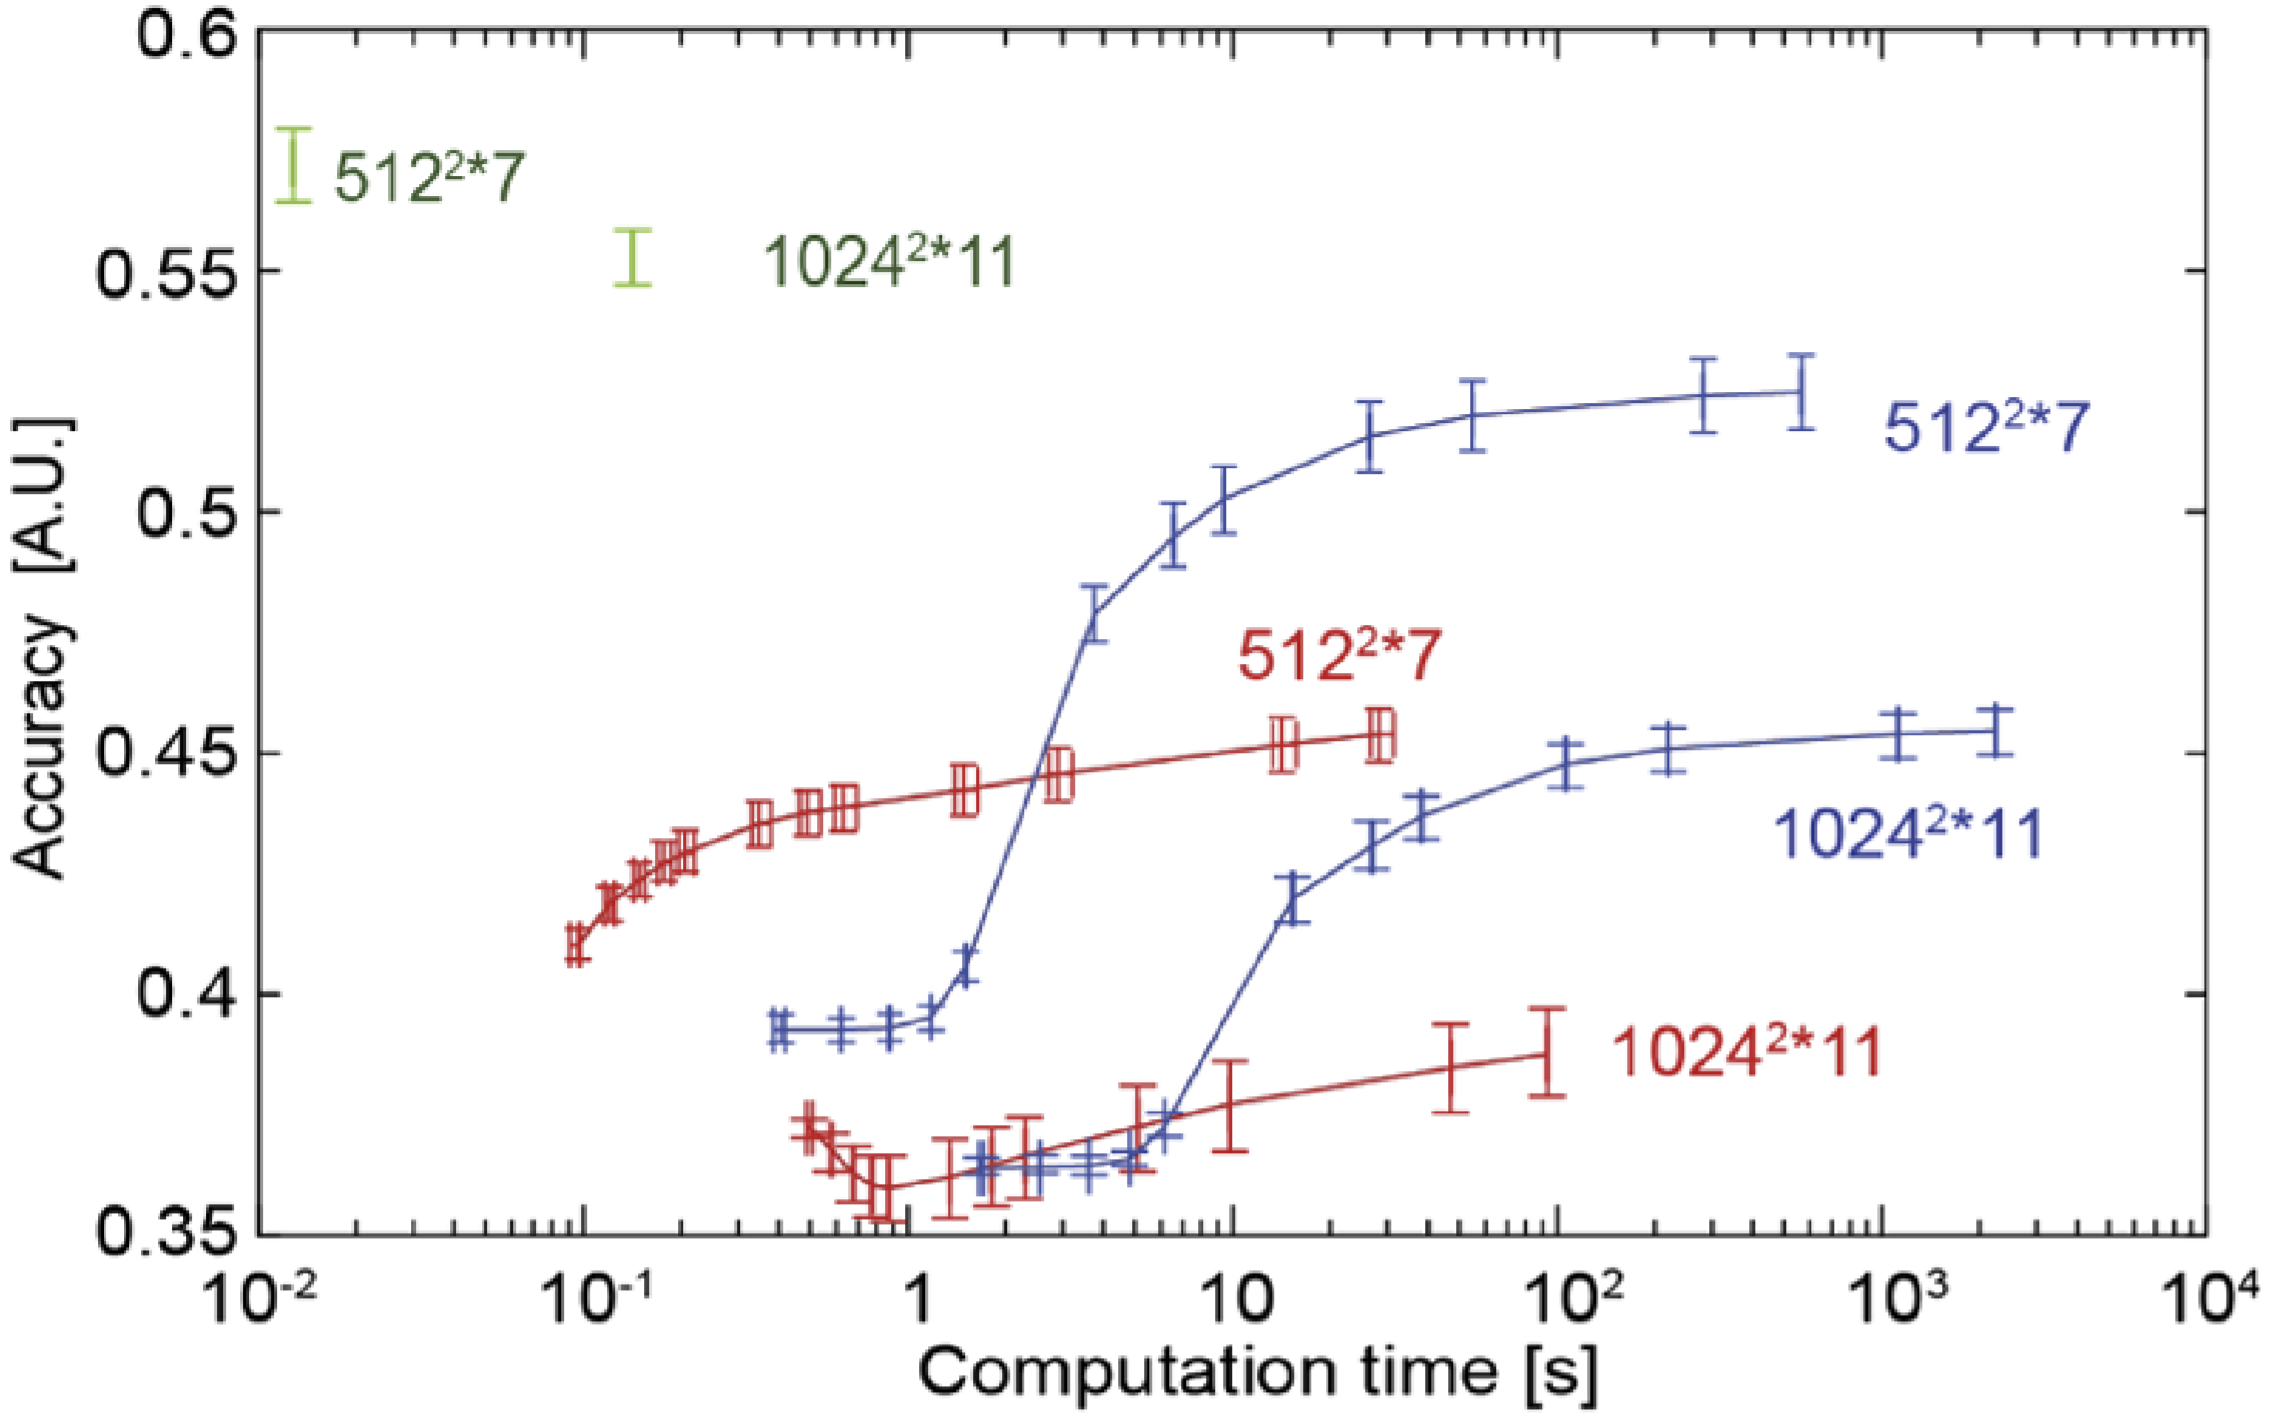